In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [6]:
# Make a list of chars
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars
# Dictionnary char to index
stoi = {s:i for i,s in enumerate(chars)}
# Dictionnary index to char
itos = {i:s for s,i in stoi.items()}

In [16]:
block_size = 4

def build_dataset(words, block_size):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

In [17]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train = words[:n1]
dev = words[n1:n2]
test = words[n2:]

Xtr, Ytr = build_dataset(train, block_size)
Xdev, Ydev = build_dataset(dev, block_size)
Xte, Yte = build_dataset(test, block_size)

E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [18]:
emb_dim = 10
in_size = block_size * emb_dim
hidden_size = 256
out_size = len(chars)

lr = 0.1
lambda_ = 0.01
batch_size = 300

In [21]:
g = torch.Generator().manual_seed(42)
C = torch.randn((out_size, emb_dim), generator=g) # Embedding matrix
W1 = torch.randn((in_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, out_size), generator=g)
b2 = torch.randn(out_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(f'{sum(p.nelement() for p in parameters)=}')

for p in parameters:
  p.requires_grad = True

lossi = []
stepi = []

sum(p.nelement() for p in parameters)=17705


In [22]:
for i in range(300000):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

  # Forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % 10000 == 0:
    print(f"mini batch {i} | loss {loss.item()} at lr {lr}")

mini batch 0 | loss 28.155576705932617 at lr 0.1
mini batch 10000 | loss 2.3577139377593994 at lr 0.1
mini batch 20000 | loss 2.2117621898651123 at lr 0.1
mini batch 30000 | loss 2.241863250732422 at lr 0.1
mini batch 40000 | loss 2.2811520099639893 at lr 0.1
mini batch 50000 | loss 2.295607089996338 at lr 0.1
mini batch 60000 | loss 2.1925876140594482 at lr 0.1
mini batch 70000 | loss 2.116612672805786 at lr 0.1
mini batch 80000 | loss 2.2323737144470215 at lr 0.1
mini batch 90000 | loss 2.027623414993286 at lr 0.1
mini batch 100000 | loss 2.127627372741699 at lr 0.01
mini batch 110000 | loss 2.1775400638580322 at lr 0.01
mini batch 120000 | loss 2.1705405712127686 at lr 0.01
mini batch 130000 | loss 2.0680365562438965 at lr 0.01
mini batch 140000 | loss 2.1269454956054688 at lr 0.01
mini batch 150000 | loss 2.0743520259857178 at lr 0.01
mini batch 160000 | loss 2.0979528427124023 at lr 0.01
mini batch 170000 | loss 1.9895522594451904 at lr 0.01
mini batch 180000 | loss 1.950185775756

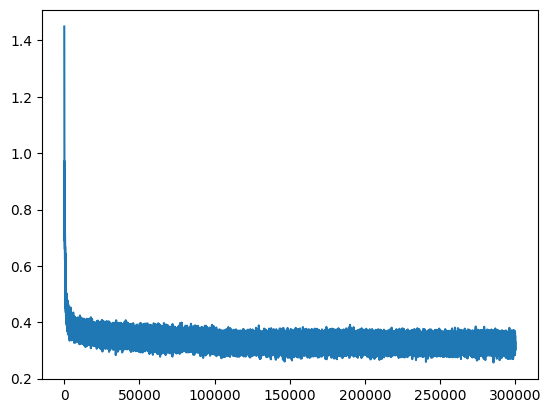

In [23]:
plt.plot(stepi, lossi)

In [24]:
# Evaluation with training
emb = C[Xtr]
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"Training set loss {loss.item()}")

# Evaluation with dev
emb = C[Xdev]
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"Dev set loss {loss.item()}")


Training set loss 2.114255905151367
Dev set loss 2.1415328979492188


E02: Initialization of the network.

(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?

In [27]:
# Evaluation with training
emb = C[Xtr]
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
torch.nn.init.uniform_(logits, 0, 1)
loss = F.cross_entropy(logits, Ytr)
print(f"Training set loss {loss.item()}")

# Evaluation with dev
emb = C[Xdev]
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
torch.nn.init.uniform_(logits, 0, 1)
loss = F.cross_entropy(logits, Ydev)
print(f"Dev set loss {loss.item()}")

Training set loss 3.3361880779266357
Dev set loss 3.337000608444214


(2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [25]:
torch.nn.init.normal_(C, 0, 0.01)
torch.nn.init.normal_(W1, 0, 0.01)
torch.nn.init.normal_(b1, 0, 0.01)
torch.nn.init.normal_(W2, 0, 0.01)
torch.nn.init.normal_(b2, 0, 0.01)
X = Xtr
Y = Ytr
parameters = [C, W1, b1, W2, b2]

print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

number of params = 17705


In [26]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"Starting loss {loss.item()}")

Starting loss 3.2982730865478516


E03: Read the Bengio et al 2003 paper, implement and try any idea from the paper. Did it work?

- Regularization implemented but small effec on validation loss.